In [1]:
# ==============================================================================
# DISCLAIMER IMPORTANTE PARA AMBIENTES GOOGLE COLAB
# ==============================================================================
# Como o Google Colab fornece um ambiente de execução temporário, ele não vem
# com Java ou Spark pré-instalados. Portanto, este bloco de código DEVE SER
# EXECUTADO TODA VEZ que você iniciar ou reiniciar uma sessão (runtime) no Colab
# para instalar e configurar todas as dependências necessárias para o PySpark.
# ==============================================================================


# --- Bloco de Instalação e Configuração do Ambiente Spark ---

# 1. Instalação do Java
# O Apache Spark é executado sobre a Java Virtual Machine (JVM), então o Java é um pré-requisito obrigatório.
# !apt-get update -qq: Atualiza a lista de pacotes do sistema operacional (baseado em Debian/Ubuntu). O '-qq' torna a saída mais silenciosa.
!apt-get update -qq
# !apt-get install: Instala o OpenJDK 11 (uma versão de código aberto do Java) sem interação do usuário (-y).
!apt-get install -y openjdk-11-jdk-headless

# 2. Download do Spark
# Baixa os binários pré-compilados do Apache Spark a partir do site oficial de arquivamento da Apache.
# !wget -q: Baixa o arquivo da URL especificada. O '-q' (quiet) minimiza as mensagens de log durante o download.
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# 3. Extração do Spark
# Descompacta o arquivo .tgz que foi baixado no passo anterior.
# !tar -xvzf:
#   x: eXtract (extrair)
#   v: verbose (mostra os arquivos sendo extraídos)
#   z: gZip (indica que o arquivo está compactado com gzip)
#   f: file (especifica o nome do arquivo a ser descompactado)
!tar -xvf spark-3.5.1-bin-hadoop3.tgz

# 4. Configuração das Variáveis de Ambiente
# Define as variáveis de ambiente para que o sistema operacional e o Python saibam onde encontrar as instalações do Java e do Spark.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# 5. Instalação das bibliotecas Python para Spark
# Instala as bibliotecas Python necessárias para interagir com o Spark.
# !pip install -q: Instala os pacotes usando o gerenciador de pacotes do Python (pip) em modo silencioso.
#   pyspark==3.5.1: A biblioteca que fornece a API Python para o Spark. A versão é fixada para corresponder à versão do Spark baixada.
#   findspark: Uma biblioteca útil que ajuda o Python a localizar a instalação do Spark no sistema.
!pip install -q pyspark==3.5.1 findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.27+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
s

In [48]:
from google.colab import drive, files
from pyspark.sql import SparkSession
import findspark
import requests
import gzip
import tarfile
import os
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import Row
from pyspark.sql.functions import col, count, sum, avg
findspark.init()



In [42]:
# Função para baixar arquivos
def download_file(url, file_name,stage_path):
  """
    Baixa um arquivo de uma URL e o salva em um diretório local.

    Esta função constrói a URL completa, faz uma requisição GET para baixar
    o conteúdo e o escreve em um arquivo no caminho especificado.

    Args:
        url (str): A URL base de onde o arquivo será baixado.
        file_name (str): O nome do arquivo a ser baixado (ex: "orders.json.gz").
        stage_path (str): O caminho do diretório local onde o arquivo será salvo.
  """
  response = requests.get(f"{url}/{file_name}")
  with open(f"{stage_path}/{file_name}", 'wb') as f:
      f.write(response.content)

In [41]:
def sink_data_bronze(stage_path, read_method,bronze_path, schema=None):
  """
    Ingere dados de um local de 'Stage', converte para o formato Parquet e salva na camada 'Bronze'.

    Esta função lê dados de diferentes formatos (JSON, CSV) usando Spark, e então
    escreve o DataFrame resultante em formato Parquet no caminho de destino,
    sobrescrevendo quaisquer dados existentes.

    Args:
        stage_path (str): O caminho completo para o arquivo de origem na camada 'Stage'.
        read_method (str): O método de leitura a ser usado ('json', 'csv').
                           O valor 'tar.gz' é tratado como 'csv', assumindo que o
                           caminho já aponta para o arquivo CSV extraído.
        bronze_path (str): O caminho de destino onde o arquivo Parquet será salvo
                           na camada 'Bronze'.
        schema (StructType, opcional): O schema (estrutura de colunas e tipos)
                                       a ser aplicado na leitura de arquivos CSV.
                                       Se não for fornecido, o Spark tentará inferir o schema.
                                       O padrão é None.
  """
  if read_method == "json":
      df = spark.read.json(stage_path, multiLine=False)
  elif read_method == "csv":
    if schema:
      df = spark.read.csv(stage_path, header=True, schema=schema)
    else:
      df = spark.read.csv(stage_path, header=True, inferSchema=True)
  df.write.mode("overwrite").parquet(bronze_path)

In [3]:
spark = SparkSession.builder \
    .appName("IFood Test Case") \
    .getOrCreate()

spark

In [45]:
###################################################################################
# SEÇÃO DE CONFIGURAÇÃO: ORIGEM DOS DADOS
# ---------------------------------------------------------------------------------
# Define se os arquivos de dados serão lidos a partir do Google Drive ou de uma
# pasta local (downloaded).
###################################################################################

# Variável de controle para a fonte dos dados.
# Opções válidas:
#   "drive": Para carregar os arquivos diretamente de uma pasta no Google Drive.
#   "downloaded": Para carregar os arquivos de um diretório local.
data_source = "downloaded"

# Define o caminho base no Google Drive onde os arquivos de dados estão localizados.
# Esta variável só é utilizada se 'data_source' for definida como "drive".
# Exemplo de estrutura de pastas: drive/MyDrive/iFood/Data/Stage/
drive_base_path = "drive/MyDrive/iFood/Data/Stage"

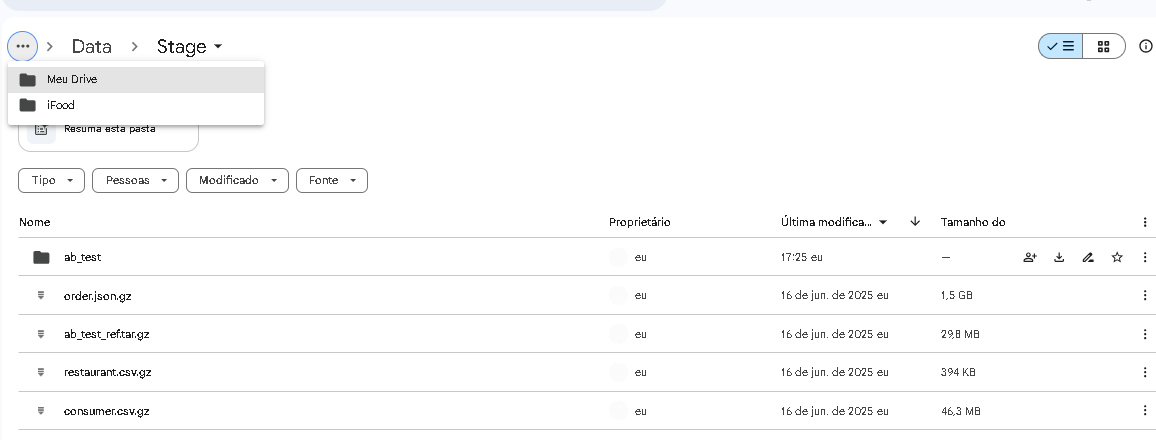

In [40]:
# --- Bloco 1: Definição dos nomes de arquivos e caminhos base ---

# Define os nomes exatos dos arquivos de origem.
# Centralizar esses nomes em variáveis facilita a manutenção do código.
orders_file = "order.json.gz"
consumers_file = "consumer.csv.gz"
restaurants_file = "restaurant.csv.gz"
ab_test_file = "ab_test_ref.tar.gz"

# Define o nome do diretório base para os arquivos baixados localmente.
downloaded_base_path = "Data"

# URL base de onde os arquivos serão baixados (neste caso, um bucket S3 da AWS).
base_url = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com"


# --- Bloco 2: Lógica para definir os caminhos com base na fonte de dados ---

# A variável `data_source` foi definida no trecho de código anterior.
# Este bloco 'if/elif/else' a utiliza para configurar os caminhos corretamente.
if data_source == "drive":
    # Se a fonte for 'drive', monta o Google Drive no ambiente de execução.
    drive.mount('/content/drive')
    #'Stage' é a área para os dados brutos ja existentes no caso de drive como input.
    stage_path = drive_base_path
    # Define o caminho para a camada 'Bronze' dentro da estrutura do Drive.
    bronze_path = f"{drive_base_path}/Bronze"

elif data_source == "downloaded":
    # Se a fonte for 'downloaded', define os caminhos para as pastas locais.
    # 'Stage' é a área para os dados brutos recém-baixados.
    stage_path = f"{downloaded_base_path}/Stage"
    # 'Bronze' é a área para os dados após um primeiro tratamento ou conversão.
    bronze_path = f"{downloaded_base_path}/Bronze"

else:
    # Se 'data_source' tiver um valor inválido, levanta um erro para parar a execução.
    # É uma boa prática para evitar comportamento inesperado do script.
    raise ValueError("Fonte de dados ('data_source') inválida. Escolha 'drive' ou 'downloaded'.")


# --- Bloco 3: Download dos arquivos (executado apenas para a fonte 'downloaded') ---

if data_source == "downloaded":
    # Cria os diretórios locais para as camadas Stage e Bronze.
    # 'exist_ok=True' evita que um erro seja lançado se os diretórios já existirem.
    os.makedirs('Data/Stage', exist_ok=True)
    os.makedirs('Data/Bronze', exist_ok=True)

    # Utiliza uma função (hipotética) 'download_file' para baixar cada arquivo da URL base
    # e salvá-lo no diretório 'stage_path'.
    print("Iniciando o download dos arquivos...")
    download_file(base_url, orders_file, stage_path)
    download_file(base_url, consumers_file, stage_path)
    download_file(base_url, restaurants_file, stage_path)
    download_file(base_url, ab_test_file, stage_path)
    print("Download concluído.")


# --- Bloco 4: Construção dos caminhos completos para os arquivos ---

# Usando f-strings, monta os caminhos completos para cada arquivo, tanto na camada
# de origem (Stage) quanto na de destino (Bronze).
# Note que os arquivos na camada Bronze terão o formato '.parquet', indicando um
# processo de conversão de formato.

# Caminhos para os dados de pedidos
orders_stage_path = f"{stage_path}/{orders_file}"
orders_bronze_path = f"{bronze_path}/orders.parquet"

# Caminhos para os dados de consumidores
consumers_stage_path = f"{stage_path}/{consumers_file}"
consumers_bronze_path = f"{bronze_path}/consumers.parquet"

# Caminhos para os dados de restaurantes
restaurants_stage_path = f"{stage_path}/{restaurants_file}"
restaurants_bronze_path = f"{bronze_path}/restaurants.parquet"


# --- Bloco 5: Tratamento específico para o arquivo de Teste A/B (.tar.gz) ---

# Define os caminhos necessários para descompactar e acessar o arquivo de teste A/B.
ab_test_stage_compressed_path = f"{stage_path}/{ab_test_file}"
ab_test_bronze_path = f"{bronze_path}/ab_test_ref.parquet"
extract_folder = f"{stage_path}/ab_test"  # Pasta de destino para o arquivo extraído
ab_target_file = "ab_test_ref.csv"        # Nome do arquivo DENTRO do .tar.gz

# Abre o arquivo compactado (.tar.gz) em modo de leitura ("r:gz")
# e extrai apenas o arquivo de interesse ('ab_target_file') para a pasta de destino.
print("Extraindo arquivo de Teste A/B...")
with tarfile.open(ab_test_stage_compressed_path, "r:gz") as tar:
    tar.extract(ab_target_file, path=extract_folder)

# Constrói o caminho completo para o arquivo CSV que foi extraído.
# os.path.join é usado para garantir a compatibilidade entre sistemas operacionais (Windows/Linux/Mac).
ab_extracted_path = os.path.join(extract_folder, ab_target_file)
print("Extração concluída.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraindo arquivo de Teste A/B...
Extração concluída.


In [36]:
# --- Bloco de Execução: Ingestão de Dados para a Camada Bronze ---
#
# Este bloco de código utiliza a função 'sink_data_bronze' para processar
# cada um dos arquivos da camada Stage, convertê-los para Parquet e
# salvá-los na camada Bronze.

# 1. Processa o arquivo de pedidos (orders)
# O método de leitura é 'json'. O Spark infere o schema de arquivos JSON de forma nativa.
print("--- Processando dados de Pedidos (Orders) ---")
sink_data_bronze(orders_stage_path, "json", orders_bronze_path)

# 2. Processa o arquivo de consumidores (consumers)
# O método de leitura é 'csv'. Como nenhum schema é fornecido, a função usará
# a inferência de schema do Spark (inferSchema=True), o que pode ser lento.
print("\n--- Processando dados de Consumidores (Consumers) ---")
sink_data_bronze(consumers_stage_path, "csv", consumers_bronze_path)

# 3. Processa o arquivo de restaurantes (restaurants)
# Assim como para os consumidores, este também é um CSV lido com inferência de schema.
print("\n--- Processando dados de Restaurantes (Restaurants) ---")
sink_data_bronze(restaurants_stage_path, "csv", restaurants_bronze_path)


# 4. Processa o arquivo de Teste A/B (ab_test) com schema explícito
print("\n--- Processando dados de Teste A/B ---")

# Para o arquivo de Teste A/B, definimos o schema manualmente.
# Esta é a melhor prática para garantir performance e consistência dos dados.
# StructType define a estrutura do DataFrame, e StructField define cada coluna.
# StructField("nome_coluna", TipoDeDado(), aceita_nulos_?)
ab_test_schema = StructType([
    StructField("customer_id", StringType(), True),
    StructField("is_target", StringType(), True)
])

# Chama a função de ingestão passando o schema definido.
# O Spark usará este schema em vez de tentar adivinhar os tipos de dados.
sink_data_bronze(ab_extracted_path, "csv", ab_test_bronze_path, ab_test_schema)

print("\nTodos os dados foram ingeridos para a camada Bronze com sucesso! ✅")

In [37]:
dfp_orders = spark.read.parquet(orders_bronze_path)
dfp_consumers = spark.read.parquet(consumers_bronze_path)
dfp_restaurants = spark.read.parquet(restaurants_bronze_path)
dfp_ab_test = spark.read.parquet(ab_test_bronze_path)


In [38]:
# --- Bloco de Verificação: Validação da Carga de Dados na Camada Bronze ---
#
# O objetivo deste bloco é realizar um teste de sanidade (sanity check) para
# garantir que a ingestão de dados para a camada Bronze ocorreu como esperado.
# Contamos o número de registros em cada DataFrame e comparamos com os valores
# conhecidos da fonte de dados original.
#
# Esta é uma etapa crucial de Data Quality (Qualidade de Dados).

# Contagem de registros no DataFrame de pedidos (orders).
# O valor esperado, conforme a fonte, é de aproximadamente 3.6 milhões de registros.
print("Contagem de registros em 'dfp_orders':")
print(dfp_orders.count())

# Contagem de registros no DataFrame de consumidores (consumers).
# O valor esperado é de aproximadamente 806 mil registros.
print("\nContagem de registros em 'dfp_consumers':")
print(dfp_consumers.count())

# Contagem de registros no DataFrame de restaurantes (restaurants).
# O valor esperado é de aproximadamente 7 mil registros.
print("\nContagem de registros em 'dfp_restaurants':")
print(dfp_restaurants.count())

# Contagem de registros no DataFrame de teste A/B (ab_test).
# O valor esperado é de aproximadamente 806 mil registros.
print("\nContagem de registros em 'dfp_ab_test':")
print(dfp_ab_test.count())

3670826
806156
7292
806467


In [49]:
#Caso esteja usando setup de downloaded, e nao do drive, rode esse bloco para fazer o download dos parquets finais
# dessa forma voce pode fazer upload deles no proximo estagios da analise.


parquet_files_to_download = [
    orders_bronze_path,
    consumers_bronze_path,
    restaurants_bronze_path,
    ab_test_bronze_path
]

print("Preparando para baixar arquivos Parquet:")

for file_path in parquet_files_to_download:

    if os.path.exists(file_path):
        print(f"Baixando: {file_path}")
        try:

            zip_file_name = f"{os.path.basename(file_path)}.zip"
            !zip -r "{zip_file_name}" "{file_path}"
            files.download(zip_file_name)
            print(f"Download de {file_path} concluído.")
        except Exception as e:
            print(f"Erro ao baixar {file_path}: {e}")
    else:
        print(f"Arquivo não encontrado, ignorando download: {file_path}")

print("Processo de download concluído.")

Preparando para baixar arquivos Parquet:
Baixando: Data/Bronze/orders.parquet
updating: Data/Bronze/orders.parquet/ (stored 0%)
updating: Data/Bronze/orders.parquet/_SUCCESS (stored 0%)
updating: Data/Bronze/orders.parquet/.part-00000-0efcbee1-cca6-407f-94fa-13d2e86b41cc-c000.snappy.parquet.crc (deflated 0%)
updating: Data/Bronze/orders.parquet/part-00000-0efcbee1-cca6-407f-94fa-13d2e86b41cc-c000.snappy.parquet (deflated 24%)
updating: Data/Bronze/orders.parquet/._SUCCESS.crc (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download de Data/Bronze/orders.parquet concluído.
Baixando: Data/Bronze/consumers.parquet
updating: Data/Bronze/consumers.parquet/ (stored 0%)
updating: Data/Bronze/consumers.parquet/_SUCCESS (stored 0%)
updating: Data/Bronze/consumers.parquet/.part-00000-5c385b3c-0bed-440d-9b2b-2f5ca41fcc77-c000.snappy.parquet.crc (deflated 0%)
updating: Data/Bronze/consumers.parquet/part-00000-5c385b3c-0bed-440d-9b2b-2f5ca41fcc77-c000.snappy.parquet (deflated 29%)
updating: Data/Bronze/consumers.parquet/._SUCCESS.crc (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download de Data/Bronze/consumers.parquet concluído.
Baixando: Data/Bronze/restaurants.parquet
updating: Data/Bronze/restaurants.parquet/ (stored 0%)
updating: Data/Bronze/restaurants.parquet/.part-00000-37556e90-3da7-4fc5-8ef5-1f60e08e9f5a-c000.snappy.parquet.crc (stored 0%)
updating: Data/Bronze/restaurants.parquet/_SUCCESS (stored 0%)
updating: Data/Bronze/restaurants.parquet/part-00000-37556e90-3da7-4fc5-8ef5-1f60e08e9f5a-c000.snappy.parquet (deflated 30%)
updating: Data/Bronze/restaurants.parquet/._SUCCESS.crc (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download de Data/Bronze/restaurants.parquet concluído.
Baixando: Data/Bronze/ab_test_ref.parquet
updating: Data/Bronze/ab_test_ref.parquet/ (stored 0%)
updating: Data/Bronze/ab_test_ref.parquet/part-00000-93813c48-2c9d-46d1-b559-ad00e3a9eb96-c000.snappy.parquet (deflated 33%)
updating: Data/Bronze/ab_test_ref.parquet/_SUCCESS (stored 0%)
updating: Data/Bronze/ab_test_ref.parquet/.part-00000-93813c48-2c9d-46d1-b559-ad00e3a9eb96-c000.snappy.parquet.crc (deflated 0%)
updating: Data/Bronze/ab_test_ref.parquet/part-00001-93813c48-2c9d-46d1-b559-ad00e3a9eb96-c000.snappy.parquet (deflated 34%)
updating: Data/Bronze/ab_test_ref.parquet/.part-00001-93813c48-2c9d-46d1-b559-ad00e3a9eb96-c000.snappy.parquet.crc (deflated 0%)
updating: Data/Bronze/ab_test_ref.parquet/._SUCCESS.crc (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download de Data/Bronze/ab_test_ref.parquet concluído.
Processo de download concluído.
